# Mixture classification on single frequency bin

The goal of this notebook is to check whether it is possible to discrimate between different types of signals based on their respective learned models of a single frequency bin. In order to do so, the parameters from the `single_frequency_modelling_drilling.ipynb` and `single_frequency_modelling_speech.ipynb` notebooks are loaded. Furthermore, a dummy piece of audio is formed by interleaving segments of 0.5s of the original sound sources. Both models are used to perform a 1 step prediction and finally a hard classification is performed on the absolute prediction error.

From the prediction error it can be noted that this approach is capable of discriminating between signal sources based on the learned signal models. It should be noted that the approach is not ideal and should be considered a proof of concept. One problem that came up is that the predicted variance is always 1, I am not sure how to solve this. I suppose this is related to the learning of the process noise parameters which are both very large, leading to a mean/mode of approximately 1. It may be possible to let this process noise be free to be determined, since it contains information about the power of the signal from an analytical standpoint. 

Further exploration includes:
- using process noise parameter to learn signal gain
- create switching mechanism based on binomial multiplier
- allow for communication among all frequencies

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using LAR.DataAR
using FFTW

include("functions/auxiliary/buffer.jl")
include("functions/auxiliary/audioplayer.jl")
include("functions/auxiliary/workflow.jl")
include("functions/auxiliary/fourier.jl")
include("functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file_1 = "data/drilling.wav"   # specify sound location of first mixture component
sound_file_2 = "data/obama.wav"      # specify sound location of second mixture component
fs_desired = 16000                   # specify desired sampling frequency

# signal warping
nr_taps_warped = 32                  # number of taps of warped filter bank
z_pole = 0.5756                      # pole location of all-pass filter segments (0.5756 ~ approximation Bark scale)
window = rectangularwindow           # specify windowing function from fourier.jl file

# parameter loading
param_file_1 = "inferred_values/drillingnoise_AR_05.h5"
param_file_2 = "inferred_values/speech_AR_05.h5"

# inference and modelling
bin = 8                              # specify which bin to model (should be between 1 and half `nr_taps_warped`)
bin_c = "real"                       # specify whether to model the `real` or `imaginary` part
AR_order = 5                         # order of auto-regressive model
iterations = 3                       # number of iterations for variational message passing
Λ_meas = 1e10                        # assumed precision of measurement noise
;

## Load and preprocess data

In [3]:
# load and process first mixture component
x_1, fs_1 = wavread(sound_file_1, format="native")
fs_1 = Int(fs_1)
x_1 = x_1[23*fs_1+1:26*fs_1]
x_1 = resample(x_1, fs_desired/fs_1)
x_1 = 100*x_1/var(x_1)

# load and process second mixture component
x_2, fs_2 = wavread(sound_file_2, format="native")
fs_2 = Int(fs_2)
x_2 = x_2[23*fs_2+1:26*fs_2]
x_2 = resample(x_2, fs_desired/fs_2)
x_2 = 100*x_2/var(x_2)

# Combine signals according to block patern
x_tot = vcat(x_1[1:Int(fs_desired/2)], x_2[Int(1*fs_desired/2) + 1:Int(2*fs_desired/2)], x_1[Int(2*fs_desired/2) + 1:Int(3*fs_desired/2)], x_2[Int(3*fs_desired/2) + 1:Int(4*fs_desired/2)], x_1[Int(4*fs_desired/2) + 1:Int(5*fs_desired/2)], x_2[Int(5*fs_desired/2) + 1:Int(6*fs_desired/2)]);

# create time axis
t = collect((1:length(x_tot))/fs_desired)

# create audio players for demonstration
audioplayers(x_1, x_2, x_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjzuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDuAgCAkDs8bPEQPKiwbLzt+TK9nMjBvOPisjzw7IU8Ypb2PMUFUrzsieq8RDL8u0qIc7zP29u7X1ifPKrUBDypLQA96FOpu6pXWLzZmXc7BRv8OzVFxTz6BxE799cbvCiAN7xF3pi8BYssvF0WFjzQ3ac8tMygOx3vdDxYmbK88YIHvSnuXbvuXxU8Th7hPH9EKjyS6RO9X7pVvDZylTxfJu87B96TPJLKhDtZQu+8I2cgvaRz07xxGEs88eV1PXC24DulqWa6/dEnPNaiMTyf2xW91bBhvJpy1DoHHTo88Lqwuy6vqrt6GAi9RSoAPP1IOT3l5BW8crrcO+Aof7v/67i72DQBPKmTjLt4iEU8SvBfPI5B9DxmZFi6DBohvWRh07z4ZVc8YjIqvKEwqTkradA8ckEoupX3TDvHtO07Bj8SvPABZb38ed68EYW/O8U9gTzjpYk8U4QcvMJvMjzKvik8JsoiPAk8Nryv/mc8lXcKPO9kOjwUrrM79IZcvI/DPrxql4k7hndnvR5dhbwMG/u7vBRTPbe++Lz9lqg8FjPvPIfaGj1eTGe87FLBvNBEkrwQcoS8m/mhOxC+6ztw6Ys8qxQkPV6lsDqP1Ji5RInvu268ozyJnjc9F20XPIDnTbtqlAo79oyjvBLmcr2WkxO99fY2vFNnJjwe+308QfFNul24gjwxKW88R7aiuypuebpRKs27Goc+vLABm7vJDnw7BxDOvMC+YTzFiSc8FLY4vR+uLr1gl5Q8JctYvDO+Dj1lrPk8EKsyu1qtlrvYAYm8eS3XvICOlbz/0lE7gL0zPZYCzDwAA7E6wRLDvCcl4DyzOVu8lypNPKGGST03s7c8Ga4svd+oXTuf12W7SpscPMCIAr3nu0a8Co6uPLG95DtCoNo8kOSDPIAUQjwrDMy8suCLvIl9RTw+IFW9Fqr9vBLFhTyguYs7PfREOwYcPbwsiSa8qQ+Vu/xLST0ATjI9lIBHPUZOIbw06s68pbKuvHHXCr0G7ci8zMgVuz0mtzrVjwY9elc8PMwgkDrvBdy8S9lWvf6D77uT8Es83C2WPBQ3oTw5nUY93JNpPCvDjrtqM7+8TBMpvWGDErwU5jI8q46EPE9qEDzlmFg9zdJOvBmHt7zNqg69BY3pvAYwcTyD37c8I6OwOwaV1ry3FMi7x92hPLYrz7y1RSc7AUsKPSJ34LpFa5I8U+bCPJkmyry7wNK8evk1vbeeBb15uZC8zfevPGZ/Tj2Pwxo9N6h7PFwR8buSnK68mf6QvMN7y7uoOu08ynQsPdEWF7sa+oM7JTnMvEnIQTzweL+8Q5fKvIyhkTx6pbU8Scl1PEnVGbzCxZ47nEXtO67UQb0JfJy7/m1MPTYcbDsG+a46Z2V6PACd2DvAV9y83i+1vJT5Mr1YkxK8M57MPN3CgDxT646875j1OpCEU7ykax48+Z7cPOQoIT1k9hg8gu+yPPhAwbtPpV29RmNKvfhuI73ahMS8XN1RvCgFbjzGlHA7EDQEPfKj+DvdbyI8VGdJPf4WHT0LCAY9MQaivFMuh7ymdh+8mZLEvJAQdb2tDi+9rTmqvAGDAL3Ufm49NiEhPd+JETsyB0+8q3UmPak6hTyKOVg8FxE9vF97r7uf53O7VV+TO6Vxmzuz3vI88D/5OotlhLsZRT28WYplPP+AID2Y5MC7lI6WvLmgOb1Z7CG9o5IVvIZakbsIliE94ABRO6aFHbxsIic9sW4yPS/Hnbz6SJQ8oo7VPJxjLby+nPS8L5WhO3rcG72QyYO9VS73OUyLkL0ELoI7v3zMPNpsHjy58v48rOtTPa+kvTzZGo28aA4UvK/4V7tch0O8EsJoPELBSruwEg68/xHovO95K7xvMt07kwjpvGMHV70Uk1w97IcfPTR8v7wG7PQ8+ipSPfBFHTynkzw8DvkUvG+JcLz1JQA9QgQJvV8HtLxcs0M7DwDivI8IAr3q0UA8Zq61PLtN9TxxLK275zQUvKgfJz2CvSU9GD6JvOLELTo394S8x4w8vdz2nzoggCA8jO3mPMaKGb0maPq8wewUPTLm2rzQRUC92lOkOnyHnD3+cYU76zegvL044zz2N6i82tTsvLzaOD06Hsk8un3wO/3az7n9O368UCXVO/NimbwLFPa8ydYtPMh/lDx1law8r3r5O1ebAL0cZfK89WLcO6qwHTu22JQ5bGc/PMC2NLyG7Ss8SBuwOxdbQTxlnS29WiZYvR1nGr0AtvE8rLdoOulYYDwylOg8VmCZu06srjt/5qK7LXHiuyIUrTwNt4Q7KceBvHM3IT36Wbg8C7rMvOrEzDycooq85w0pvBjyKL1NUSs9McVDPP2LYzs9xik7YlkRPbQAmzx0gDa8kW4XvS+HEjuBjkO7Qn+1vNAmlDvCfNo7n4AjPa2/FDxx3tE8W+oLOiWEZb2DQOu7lmUwvIlY6rzzRUo8fqxiPL3FjrwLY8K8Zye+u6hA9LwioMI70YKtvJmgmLzHURs8Z77SPNV2WTs90Rw96QK9PDgUETz2EwU9XkbGO/gFtDxXM/K8CutxvMYbNLwruRm8PM9vvMVB2TzyujK965AVvTvWozzPd9Y8c5XMvElGlLsL2xO7Lzf1O6ZL/zxkyGW8hsdoOzqpoTxT/X88Mbz+vD4tLj1kyCI9M1nhvNce37wMDMe7mr7Ruz6ySLtGP1+8bPCZvKOtaTu6Ygm9DXShO9qwpTzGhi8823inPM6aDD1p0u08op40vD5AOL25szQ8mNzGPEcqJjxyLAY9EeboPNLLQrx+DRy9T3GPvPE80Lw0RCm8NFaHvCrTObsslgg8jFIhvcw4DT1StjA9dP+mPKjbg7xDQrQ8+IkwvMEWYL0loWe8lBi1PHMiFTxNahM88bhyva9RZL343dA8GudBPSgg2bzM+X88Age/PBNT/Dy+i9K7BDLDu+qXCzuZIv68Fe2GPOWbyjy8wm47IpAivR33pTy/og+5vZsdvAF0rjxEITI8z1knPauxbrzHtLi8M6yUvM3DwDy+vwk9VYo1PKH907uFx1u9Gav8vEeu1bySQjq8rzAlPZJdED0KB988W37oux0oJ71mPTS9SVBmvJ1XqzzC5gk93PmEvJRLE7wC55I71nSrvLsaIrwKtnU85G42PEV9SryhAYk8qfqLPLccrDyTY1W8N6NgvCr0SrtYkQ49czMXPG9lxrwG5z288BECvA1UTTutMK47FVQmPOlNKTxppEU7PK6QPBDvxjwV/Pq82r8VvHQywrv4Jaq8kJWGvFElArxwKdU8+yFauwIBNro4LCw9uhEuOpViTb1t6yW9mBvdPMFQyjxAqzE8jxo/PF7mvru7Lkq6FSGPvJVVLDyEbLW85F06PWPoBz1QZI+7c3GUPPjn77xGAtu8toSPvD/4ljyNKPe866icupLmpbtEpYM8Pj0DPXQQpLyRak28QomBO8FJzjwNgWC75F+3vKrh8bvqRIO8Um4tvErrxbxYyB861/iMPKFIwrwH1FE8hwc8PGLdNr2E96481oMuPaK00zzgjM48hXhzPCASC70B0hO8aO8AvGl+sztFPEY9N4+GPCoBmr2AbRe9vFe/u5cgJrz8V547pukRPWIG/DwSBNi88+QIPKO6dTwEGSK88y/BO+dXOj1D+Ig8r1UEveC7vTzR3J87C0LBvL8Rdby8VJQ7YkLku0FSe7oVoDY79Tc8vZs4xbwqfsK6veiWu7QhN7qY7l49kbswu0kuzLzs89C85iwtPYDeMTyKZ9y7IwtCPb+pW7vtBj69cyi0unaj/LwMmq+7GGfFOsncz7wbyRI9j0k6u7FVVDvD60U8ZW37PN0tPj2Ob8c7O0+cPO2TjrxAYiW8ipVPvGuZEL0w/

## Visualize data

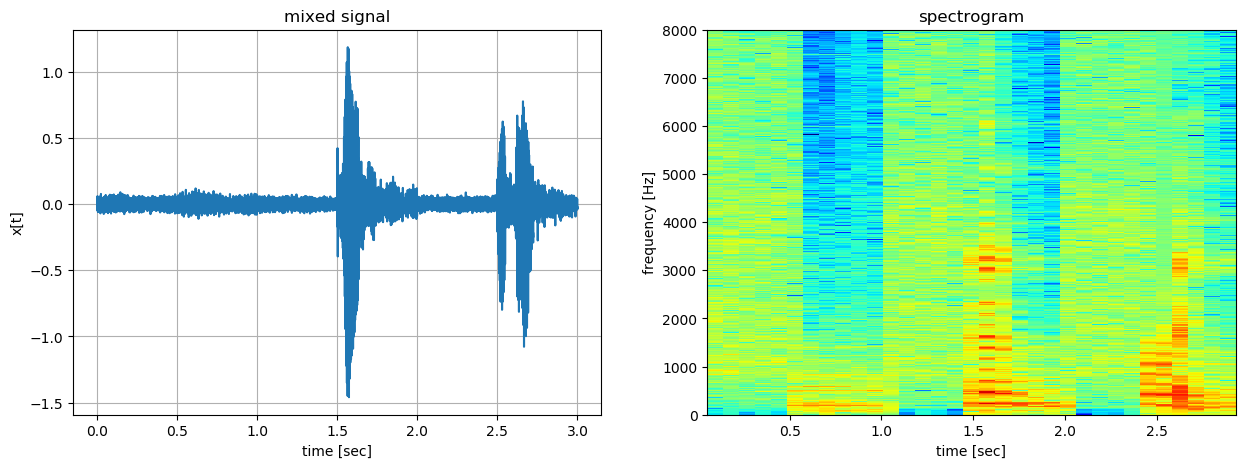

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_tot)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("mixed signal"), ax[2].set_title("spectrogram")
;

## Warp signal and calculate warped frequency distribution

In [5]:
# initialize memory vector of taps, Y, with zeros
Y = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps = Array{Array{Float64,1}}(undef, length(x_tot))
mem_spec = Array{Complex{Float64},2}(undef, length(x_tot), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_tot)
    
    # update memory vector of taps and taps themselves
    Y, mem_taps[k] = allpass_update(x_tot[k], Y, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec = mem_spec[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
;

## Warped spectral distribution visualization

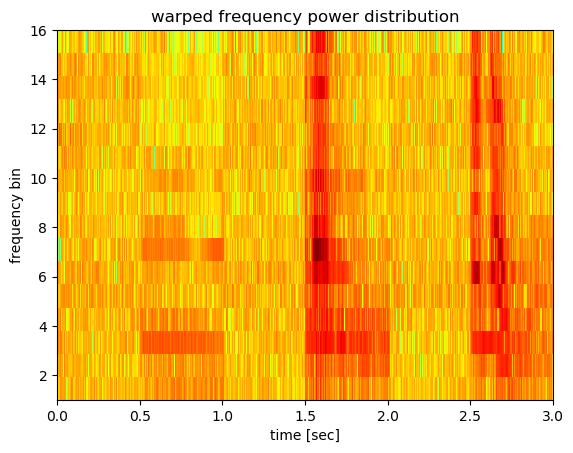

In [6]:
# calculate power of spectral components
mem_spec_pwr = 20*log10.(abs.(mem_spec))'

# plot warped power spectrum
plt.imshow(mem_spec_pwr, aspect="auto", cmap="jet", origin="lower", extent=[t[1], t[end], 1, Int(floor(nr_taps_warped/2))]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
;

## Single bin visualization

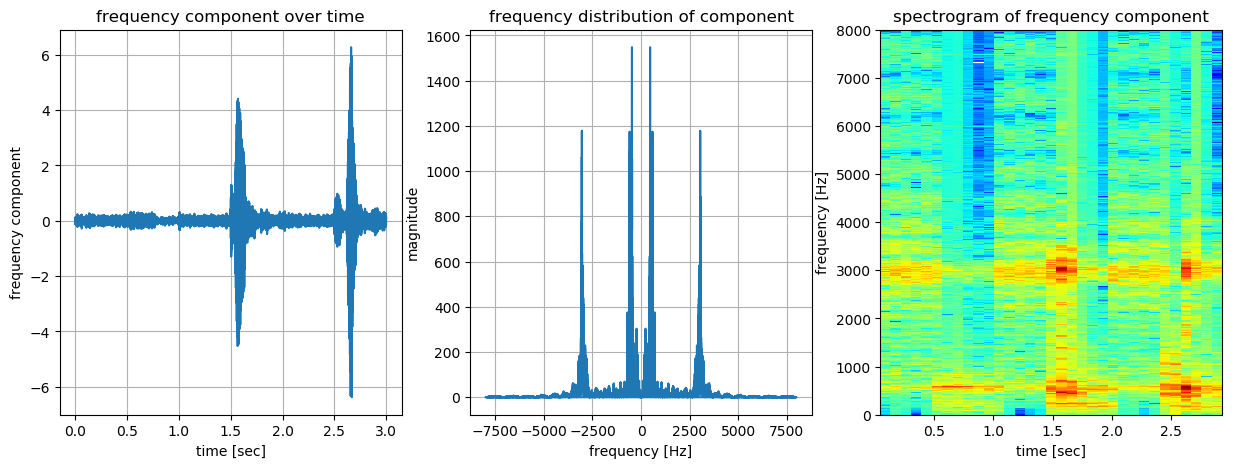

In [7]:
# select specified frequency bin
if bin_c == "real"
    spec_select = mem_spec_real[:, bin]
else
    spec_select = mem_spec_imag[:, bin]
end

# create subplots
_, ax = plt.subplots(ncols=3, figsize=(15,5))

# plot frequency component as a function of time
ax[1].plot(t, spec_select)

# plot frequency distribution of frequency component
ax[2].plot(FFTW.fftfreq(length(spec_select), fs_desired), abs.(FFTW.fft(spec_select)))

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(spec_select, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])

# change visuals
ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("frequency component over time"), ax[2].grid(), ax[2].set_xlabel("frequency [Hz]"), ax[2].set_ylabel("magnitude"), ax[2].set_title("frequency distribution of component"), ax[3].set_title("spectrogram of frequency component")
;

## Load parameters

In [8]:
if bin_c == "real"
    params_1 = h5read(param_file_1, "bin_real_"*string(bin, pad=2))
    params_2 = h5read(param_file_2, "bin_real_"*string(bin, pad=2))
else
    params_1 = h5read(param_file_1, "bin_imag_"*string(bin, pad=2))
    params_2 = h5read(param_file_2, "bin_imag_"*string(bin, pad=2))    
end
;

## Create generative model 1 and algorithm

In [9]:
# create factor graphs
fg_1 = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(params_1["gamma_a"], params_1["gamma_b"])
@RV θ ~ GaussianMeanPrecision(params_1["theta_mean"], params_1["theta_precision"])
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.AR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x + v
placeholder(y, :y)
;

In [10]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S, Sprev, ids=[:S :Sprev])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))

# create prediction function for predicted next sample (process noise variance does not seem to be learned properly)
function predict_x(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 3))

    messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=0), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=1.0e10))
    messages[2] = ruleVariationalAROutNPPP(nothing, marginals[:Sprev], marginals[:θ], marginals[:γ])
    messages[3] = ruleSPDotProductOutNPG(nothing, Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0]), messages[2])
    
    return messages[3]
    
end
;

## Create generative model 2 and algorithm

In [11]:
# create factor graphs
fg_2 = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(params_2["gamma_a"], params_2["gamma_b"])
@RV θ ~ GaussianMeanPrecision(params_2["theta_mean"], params_2["theta_precision"])
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.AR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x + v
placeholder(y, :y)
;

In [12]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S, Sprev, ids=[:S :Sprev])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorith 
eval(Meta.parse(algo))

# create prediction function for predicted next sample process noise variance does not seem to be learned properly)
function predict_x(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 3))

    messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=0), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=1.0e10))
    messages[2] = ruleVariationalAROutNPPP(nothing, marginals[:Sprev], marginals[:θ], marginals[:γ])
    messages[3] = ruleSPDotProductOutNPG(nothing, Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0]), messages[2])
    
    return messages[3]
    
end
;

## Perform inference

In [13]:
# priors
current1_μ_Sprev = randn(AR_order)
current1_Λ_Sprev = tiny*diagm(randn(AR_order))
current2_μ_Sprev = randn(AR_order)
current2_Λ_Sprev = tiny*diagm(randn(AR_order))
μ1_S_tot = []
Λ1_S_tot = []
μ2_S_tot = []
Λ2_S_tot = []
μ1_pred = Float64[]
σ1_pred = Float64[]
μ2_pred = Float64[]
σ2_pred = Float64[]

p = Progress(length(spec_select), 1, "Observed ")
marginals1 = Dict()
marginals2 = Dict()
data1 = Dict()
data2 = Dict()

# loop through signal samples
for sp in 1:length(spec_select)
    
    # update progress bar
    update!(p, sp)
    
    # update marginals
    marginals1[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_1["theta_mean"], w=params_1["theta_precision"])
    marginals1[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_1["gamma_a"], b=params_1["gamma_b"])
    marginals1[:Sprev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current1_μ_Sprev, w=current1_Λ_Sprev)
    marginals2[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_2["theta_mean"], w=params_2["theta_precision"])
    marginals2[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_2["gamma_a"], b=params_2["gamma_b"])
    marginals2[:Sprev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current2_μ_Sprev, w=current2_Λ_Sprev)    
       
    # update data dictionary
    data1 = Dict(:y => spec_select[sp],
                 :μ_Sprev => current1_μ_Sprev,
                 :Λ_Sprev => current1_Λ_Sprev)
    data2 = Dict(:y => spec_select[sp],
                 :μ_Sprev => current2_μ_Sprev,
                 :Λ_Sprev => current2_Λ_Sprev)  
    
    # perform prediction of current sample
    push!(μ1_pred, ForneyLab.unsafeMean(predict_x(data1, marginals1).dist))
    push!(σ1_pred, ForneyLab.unsafeVar(predict_x(data1, marginals1).dist))
    push!(μ2_pred, ForneyLab.unsafeMean(predict_x(data2, marginals2).dist))
    push!(σ2_pred, ForneyLab.unsafeVar(predict_x(data2, marginals2).dist))
    
    # perform VMP iterations
    for it = 1:iterations
        
        # update data dictionary
        data1 = Dict(:y => spec_select[sp],
                     :μ_Sprev => current1_μ_Sprev,
                     :Λ_Sprev => current1_Λ_Sprev)
        data2 = Dict(:y => spec_select[sp],
                     :μ_Sprev => current2_μ_Sprev,
                     :Λ_Sprev => current2_Λ_Sprev)      
        
        # perform inference
        setCurrentGraph(fg_1)
        data1, marginals1 = step_all!(data1, marginals1)
        setCurrentGraph(fg_2)
        data2, marginals2 = step_all!(data2, marginals2)
        
        # save new parameters
        push!(μ1_S_tot, ForneyLab.unsafeMean(marginals1[:S])[1])
        push!(Λ1_S_tot, ForneyLab.unsafePrecision(marginals1[:S])[1])
        push!(μ2_S_tot, ForneyLab.unsafeMean(marginals2[:S])[1])
        push!(Λ2_S_tot, ForneyLab.unsafePrecision(marginals2[:S])[1])
        
        # update current parameters
        current1_μ_Sprev = ForneyLab.unsafeMean(marginals1[:Sprev])
        current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals1[:Sprev])
        current2_μ_Sprev = ForneyLab.unsafeMean(marginals2[:Sprev])
        current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals2[:Sprev])
    end
    
    # update current parameters
    current1_μ_Sprev = ForneyLab.unsafeMean(marginals1[:S])
    current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals1[:S])
    current2_μ_Sprev = ForneyLab.unsafeMean(marginals2[:S])
    current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals2[:S])
end
;

Observed 100%|██████████████████████████████████████████| Time: 0:01:289:29


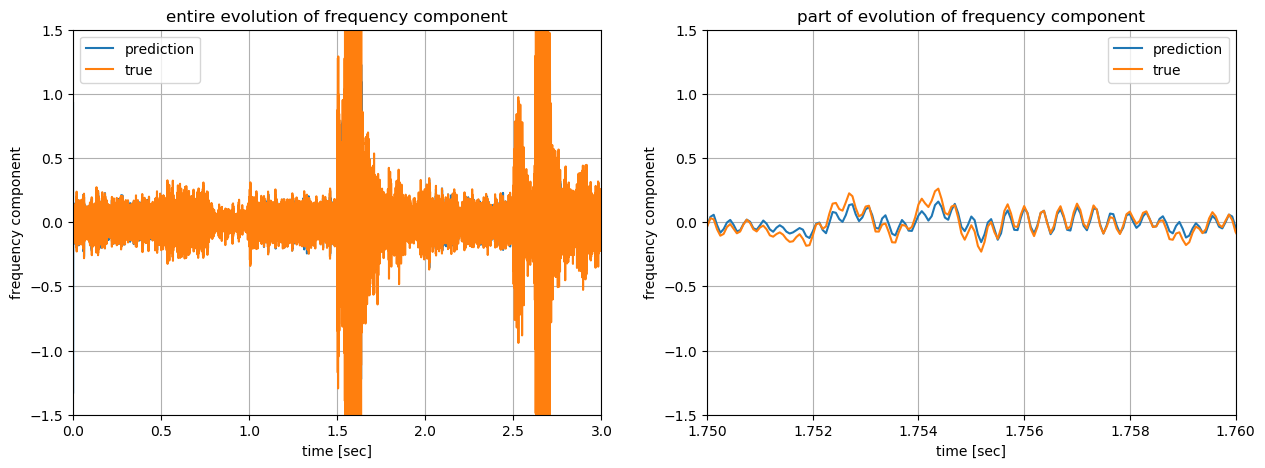

In [14]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t[1:end], μ1_pred[1:end], label="prediction"), ax[2].plot(t[1:end], μ1_pred[1:end], label="prediction")

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], spec_select[1:end], label="true"), ax[2].plot(t[1:end], spec_select[1:end], label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("entire evolution of frequency component"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("frequency component"), ax[2].set_title("part of evolution of frequency component")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-1.5,1.5)
;

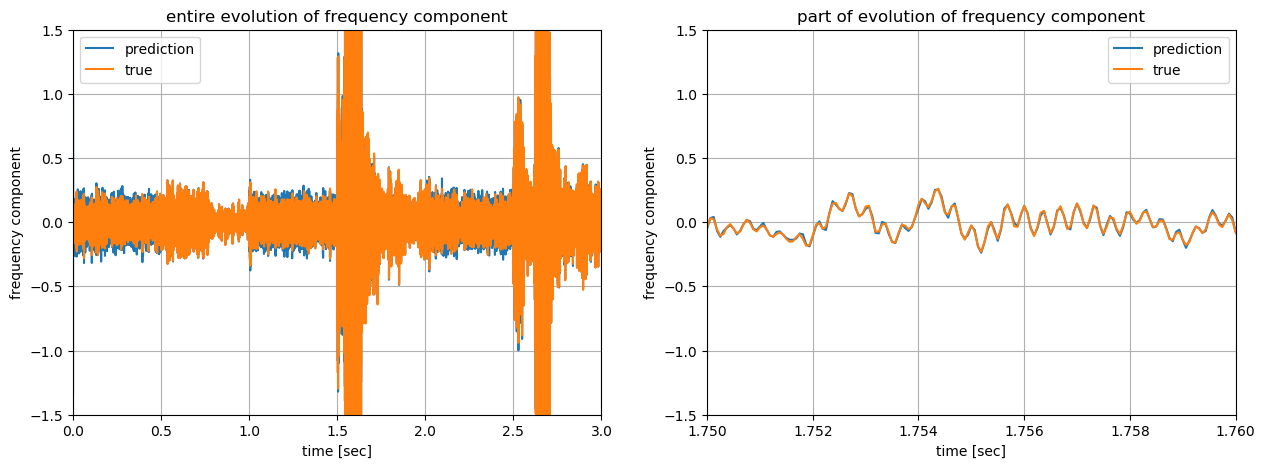

In [15]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t[1:end], μ2_pred[1:end], label="prediction"), ax[2].plot(t[1:end], μ2_pred[1:end], label="prediction")

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], spec_select[1:end], label="true"), ax[2].plot(t[1:end], spec_select[1:end], label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("entire evolution of frequency component"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("frequency component"), ax[2].set_title("part of evolution of frequency component")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-1.5,1.5)
;

## Calculate error and hard classification

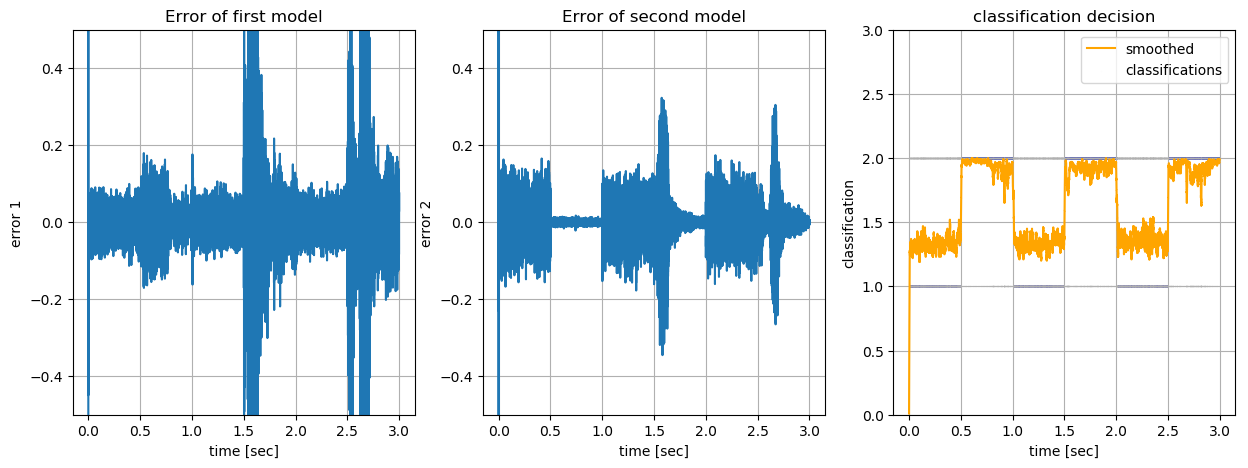

In [16]:
# calculate errors
error1 = spec_select - μ1_pred
error2 = spec_select - μ2_pred

# determine classification
class = [abs(er1) < abs(er2) ? 1 : 2 for (er1, er2) in zip(error1, error2)]
class_smooth = DSP.conv(class, 1/100*ones(100))[1:length(class)]

# plot results
_, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[1].plot(t, error1)
ax[2].plot(t, error2)
ax[3].scatter(t, class, s=0.8, alpha=0.002, label="classifications")
ax[3].plot(t, class_smooth, color="orange", label="smoothed")

ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("error 1"), ax[1].grid(), ax[1].set_ylim(-0.5, 0.5), ax[1].set_title("Error of first model")
ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("error 2"), ax[2].grid(), ax[2].set_ylim(-0.5, 0.5), ax[2].set_title("Error of second model")
ax[3].set_xlabel("time [sec]"), ax[3].set_ylabel("classification"), ax[3].grid(), ax[3].set_ylim(0,3), ax[3].set_title("classification decision"), ax[3].legend()
;